
📍 Processing station: Badgerys_Creek_AWS


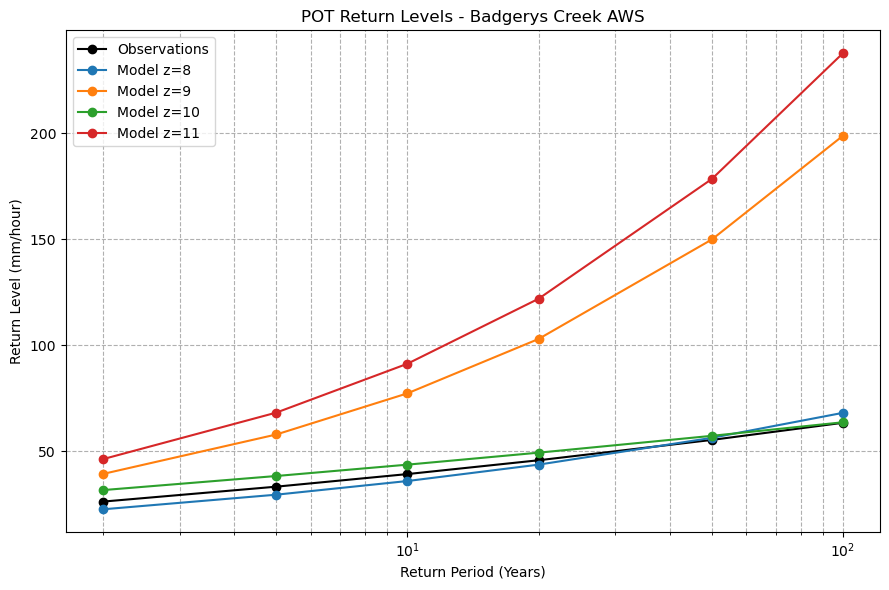


📍 Processing station: Richmond_RAAF
⚠️ Not enough exceedances at zoom 8. Skipping.


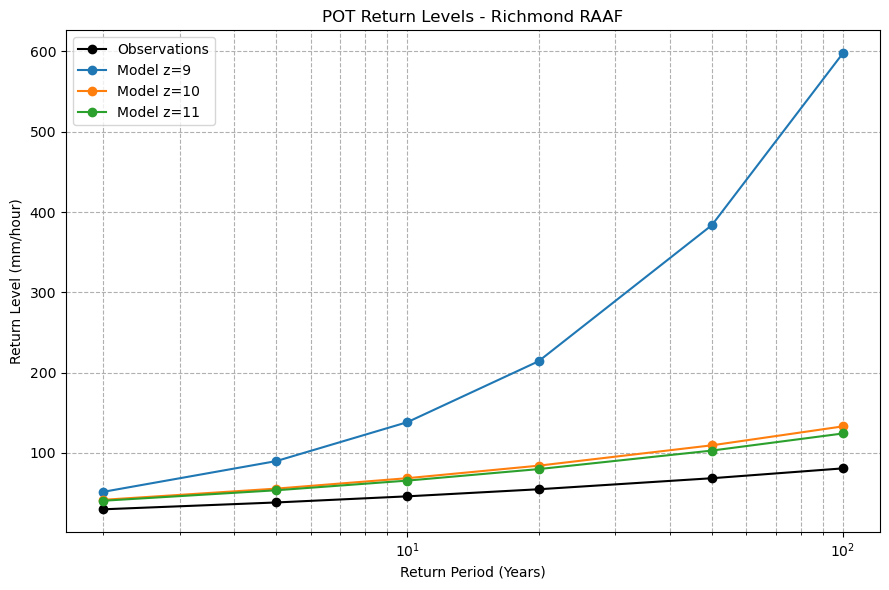


📍 Processing station: Bankstown_Airport_AWS


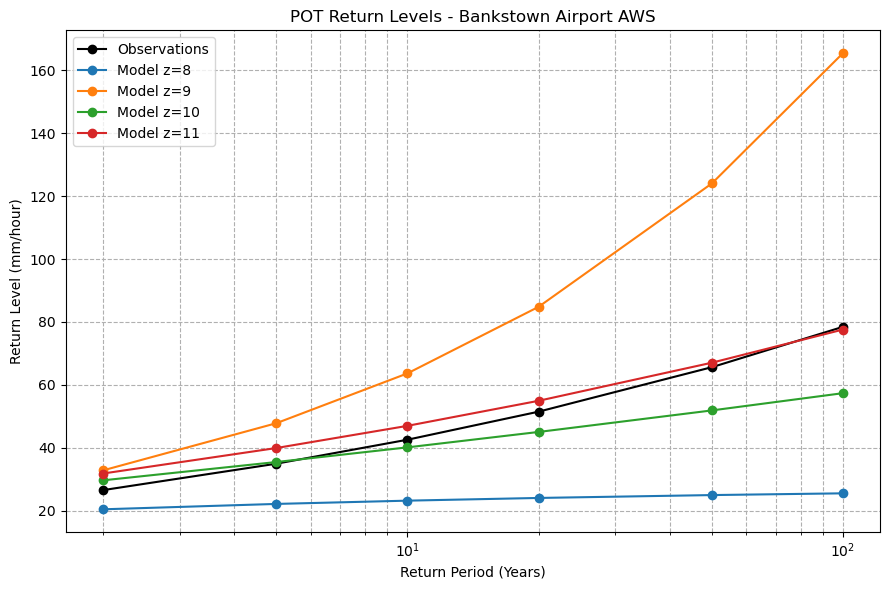


📍 Processing station: Sydney_Airport_AMO
⚠️ Not enough exceedances at zoom 8. Skipping.


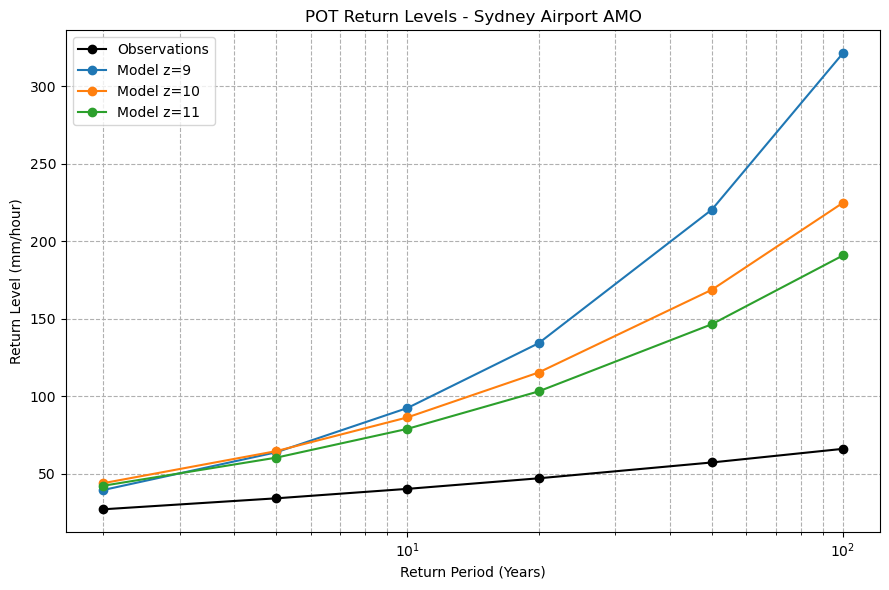


📍 Processing station: Norah_Head_AWS


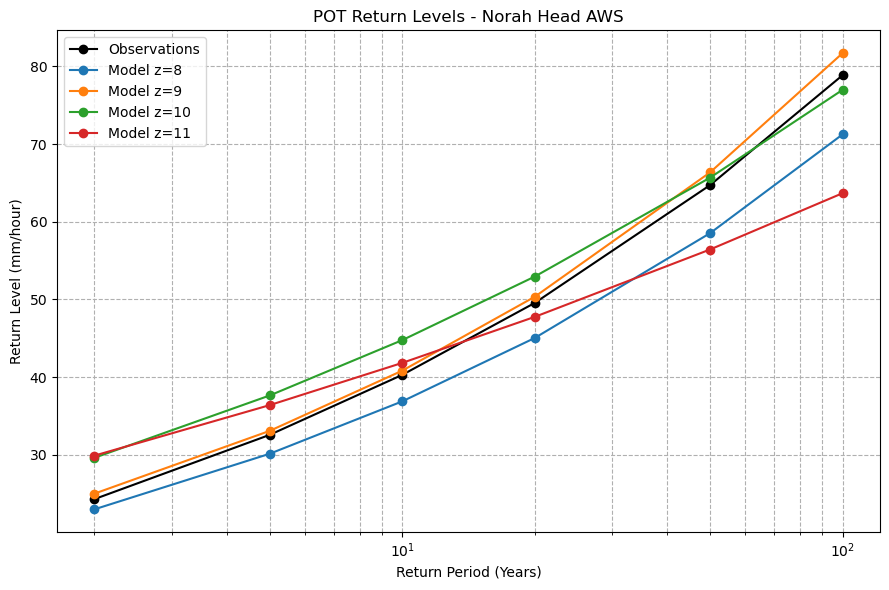

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto
import os

# === Setup ===

stations = {
    "badgery": "Badgerys_Creek_AWS",
    "richmond": "Richmond_RAAF",
    "bankstown": "Bankstown_Airport_AWS",
    "sydney": "Sydney_Airport_AMO",
    "norah": "Norah_Head_AWS",
}

zoom_levels = [8, 9, 10, 11]

base_obs_path = "~/hackathon/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney"
base_model_path = "~/excel_exports"

hours_per_year = 365.25 * 24
return_periods = np.array([2, 5, 10, 20, 50, 100])

def hours_between(start, end):
    return (end - start).total_seconds() / 3600

for obs_id, model_id in stations.items():
    print(f"\n📍 Processing station: {model_id}")

    # === Load observation ===
    obs_file = os.path.expanduser(f"{base_obs_path}/{obs_id}_1h.csv")
    obs_df = pd.read_csv(obs_file, parse_dates=["Time"])
    obs_df = obs_df.rename(columns={"Time": "time", "Precipitation": "value"})
    obs_df = obs_df[obs_df['value'] > 0.2]

    if obs_df.empty:
        print("⚠️ No data found in obs.")
        continue

    # Threshold from obs
    threshold = np.percentile(obs_df['value'], 95)

    obs_exc = obs_df[obs_df['value'] > threshold].copy()
    obs_exc['excess'] = obs_exc['value'] - threshold
    shape_obs, loc_obs, scale_obs = genpareto.fit(obs_exc['excess'], floc=0)
    total_hours_obs = hours_between(obs_df['time'].min(), obs_df['time'].max())
    rate_obs = len(obs_exc) / total_hours_obs

    # Return levels for obs
    return_levels_obs = []
    for T in return_periods:
        prob = 1 - 1 / (rate_obs * T * hours_per_year)
        rl = threshold + genpareto.ppf(prob, shape_obs, loc=0, scale=scale_obs)
        return_levels_obs.append(rl)

    # === Plotting ===
    plt.figure(figsize=(9, 6))
    plt.plot(return_periods, return_levels_obs, 'ko-', label='Observations')

    for zoom in zoom_levels:
        model_file = os.path.expanduser(f"{base_model_path}/germany_node_{model_id}_z{zoom}.csv")

        if not os.path.exists(model_file):
            print(f"⛔ Missing model file for zoom {zoom}, skipping.")
            continue

        model_df = pd.read_csv(model_file, parse_dates=["time"])
        model_df = model_df[model_df['value'] > 0.2]

        mod_exc = model_df[model_df['value'] > threshold].copy()
        mod_exc['excess'] = mod_exc['value'] - threshold

        if len(mod_exc) < 20:
            print(f"⚠️ Not enough exceedances at zoom {zoom}. Skipping.")
            continue

        shape_mod, loc_mod, scale_mod = genpareto.fit(mod_exc['excess'], floc=0)
        total_hours_mod = hours_between(model_df['time'].min(), model_df['time'].max())
        rate_mod = len(mod_exc) / total_hours_mod

        return_levels_mod = []
        for T in return_periods:
            prob = 1 - 1 / (rate_mod * T * hours_per_year)
            rl = threshold + genpareto.ppf(prob, shape_mod, loc=0, scale=scale_mod)
            return_levels_mod.append(rl)

        plt.plot(return_periods, return_levels_mod, marker='o', label=f'Model z={zoom}')

    # === Final plot formatting ===
    plt.xscale('log')
    plt.xlabel('Return Period (Years)')
    plt.ylabel('Return Level (mm/hour)')
    plt.title(f'POT Return Levels - {model_id.replace("_", " ")}')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()
